In [1]:
import pandas as pd
#import matplotlib.pyplot as plt
from utils import preprocess
# from neuralforecast import NeuralForecast
# from neuralforecast.models import LSTM #DeepAR,NHITS,RNN,
# import torch
# from typing import Union
# from neuralforecast.losses.pytorch import MSE
# from neuralforecast.losses.pytorch import BasePointLoss
# from neuralforecast import NeuralForecast
# from neuralforecast.models import LSTM,GRU
# from neuralforecast.utils import augment_calendar_df
# from utils.losses import customLoss
from statsforecast import StatsForecast
from statsforecast.models import HoltWinters,IMAPA,AutoETS,AutoARIMA,AutoTheta


df = pd.read_csv('data/01_input_history.csv')
df.head()


df_train_null, df_train_inactive, df_train_active, df_validation = preprocess.preprocess_ex1(df)

df_train_merged = df_train_active#pd.merge(df_train_active, df_train_inactive, how='outer', on=['unique_id', 'ds', 'Quantity', 'Country', 'Product'])
df_train_merged = pd.get_dummies(df_train_merged, columns=['Country', 'Product'], drop_first=True)


In [157]:
# Forecasting horizon
H = 12  # 12 months ahead

# Set up the model
sf = StatsForecast(
    models=[
        #HoltWinters(season_length=12, error_type="A"),
        #MSTL(season_length=12),
        #GARCH(p=1, q=1),
        IMAPA(),
    ],
    freq='MS',
    n_jobs=-1
)

# Fit the model
sf.fit(
    df_train_active[['unique_id', 'ds', 'Quantity']],
    target_col='Quantity',
    )

StatsForecast(models=[IMAPA])

In [160]:
y_hat = sf.predict(h=H)

In [161]:
y_hat['IMAPA'] = y_hat[['IMAPA']].astype(int)

In [162]:
df_validation['ForecastHW'] = 0
for id in df_train_active['unique_id'].unique():
    df_validation.loc[df_validation['unique_id'] == id, 'Forecast'] = y_hat.loc[y_hat['unique_id'] == id, 'IMAPA'].values

In [163]:
def restore_original_format(date_column):
    return date_column.dt.strftime('%b%Y')
df_validation['Month'] = restore_original_format(df_validation['ds'])

df_validation[['Quantity','Product','Month','Country']].to_csv('submissions/validation_classical.csv', index=False)

df_forecast = df_validation[['Forecast','Country','Product','Month']].copy()
df_forecast.rename(columns={'Forecast': 'Quantity'}, inplace=True)
df_forecast[['Quantity','Product','Month','Country']].to_csv('submissions/submission_IMAPA.csv', index=False)


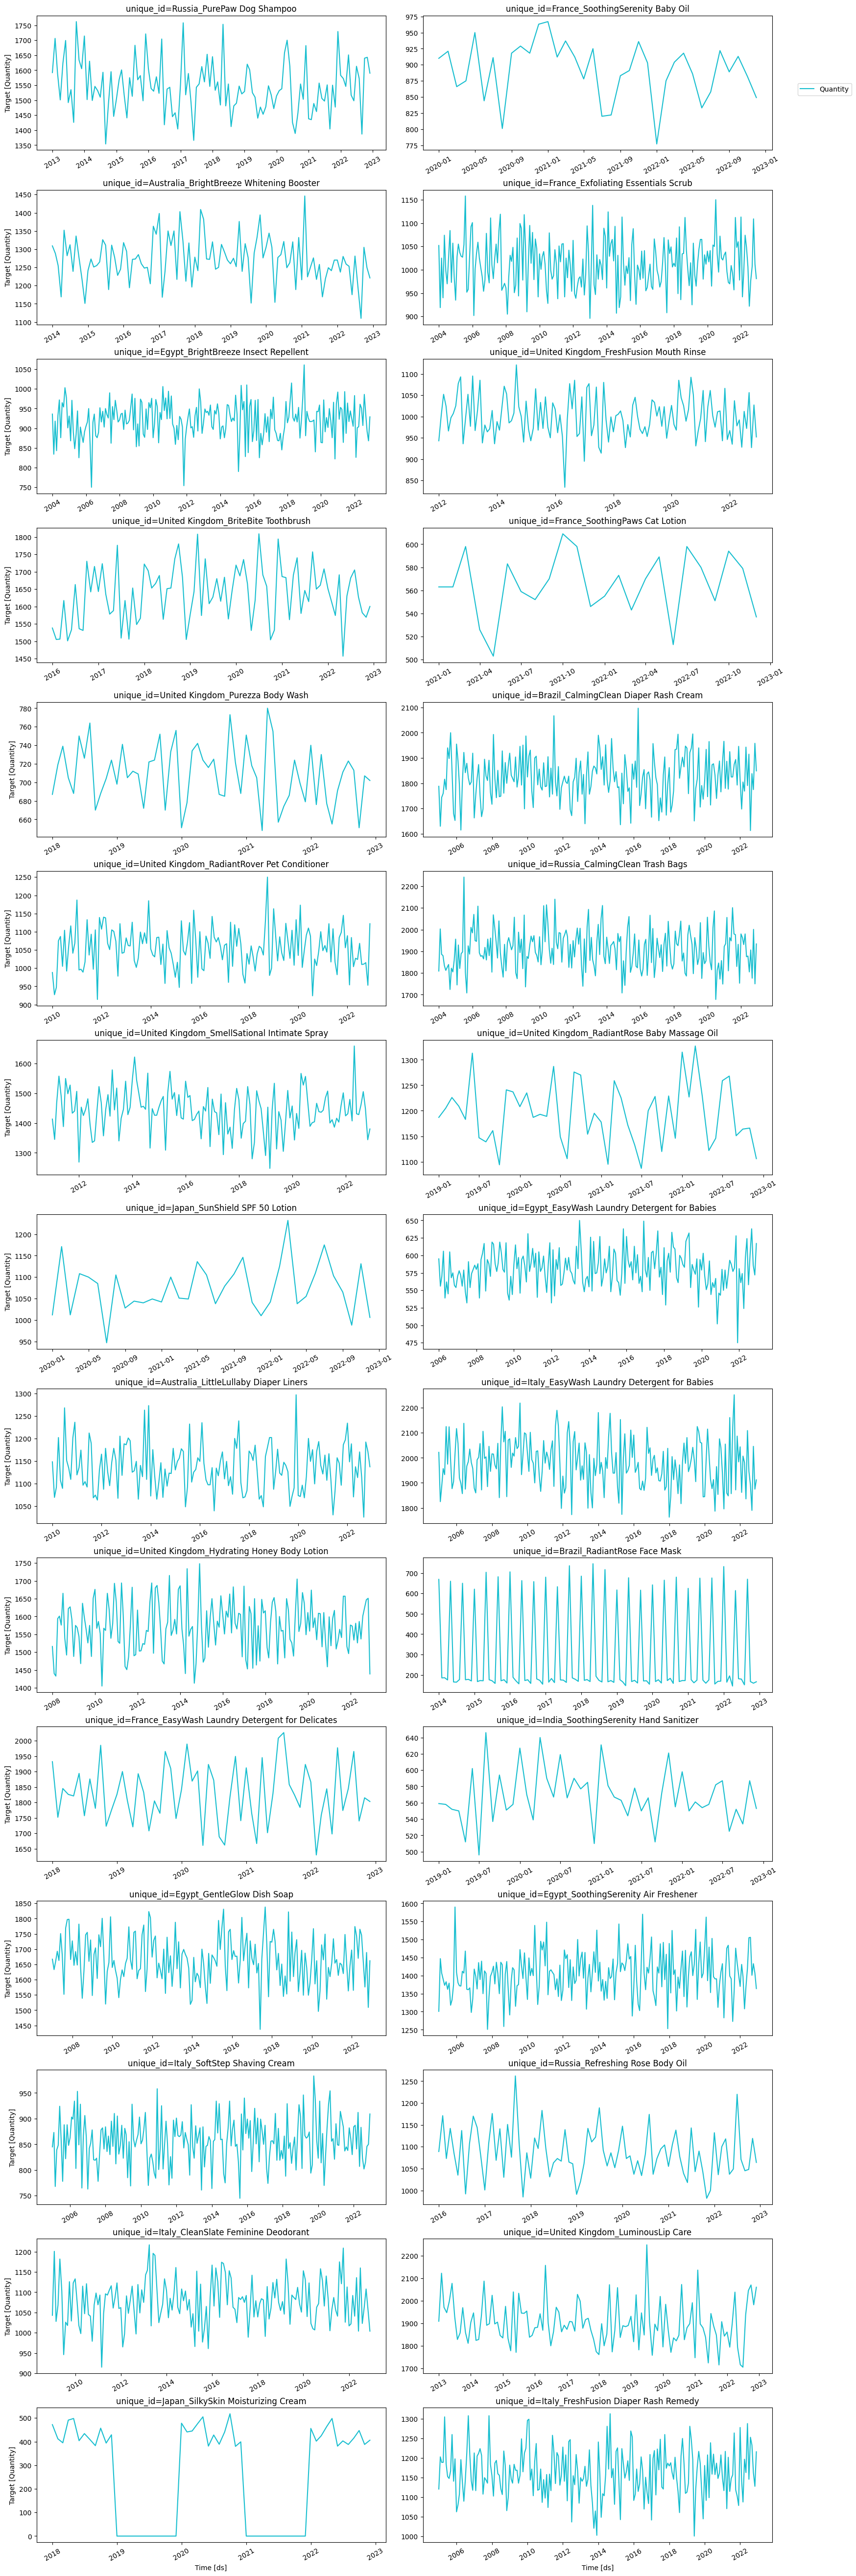

In [167]:
from utilsforecast.plotting import plot_series

plot_series(df_train_active,max_ids=30,target_col='Quantity')

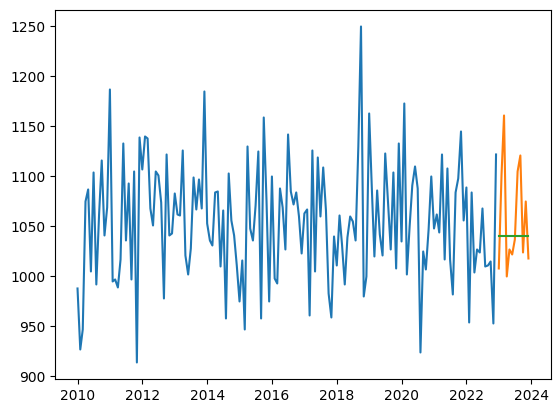

In [172]:
#id = "Brazil_RadiantRose Face Mask"
id = 'United Kingdom_RadiantRover Pet Conditioner'
import matplotlib.pyplot as plt

plt.plot(df_train_active.loc[df_train_active['unique_id'] == id, 'ds'],
         df_train_active.loc[df_train_active['unique_id'] == id, 'Quantity'], label='Train')
plt.plot(df_validation.loc[df_validation['unique_id'] == id, 'ds'],
            df_validation.loc[df_validation['unique_id'] == id, 'Quantity'], label='Validation')
plt.plot(df_validation.loc[df_validation['unique_id'] == id, 'ds'],
            df_validation.loc[df_validation['unique_id'] == id, 'Forecast'], label='Forecast')
